## Assignment 1- Ladan Tazik

Comparing run time complexity for large enough data (at least one million string) of different implementations using 

- linear search,
- binary search,
- hashing, 
- Bloom filter,
- Cuckoo filter

In [1]:
import random
import string
import time
import matplotlib.pyplot as plt
import numpy as np
import unittest
import mmh3
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

## Step 1: Generate a synthetic dataset and save in local directory

In [2]:
#  synthetic dataset of usernames of length 10
def generate_usernames(n, length=10):
    return [''.join(random.choices(string.ascii_lowercase, k=length)) for _ in range(n)]

# Create dataset of 1M
n = 1_000_000  
usernames = generate_usernames(n)

with open("synthetic_usernames.txt", "w") as file:
    for username in usernames:
        file.write(username + "\n")


## Step 2: Implementation of the search methods

In [3]:
# Function for linear search
def linear_search(username, data_list):
    """ get a list and check if username exists in the list"""
    return username in data_list

# Function for binary search
def binary_search(username, data_sortedList):
    """Binary search implementation using a sorted list."""
    left, right = 0, len(data_sortedList) - 1
    while left <= right:
        mid = (left + right) // 2
        if data_sortedList[mid] == username:
            return True
        elif data_sortedList[mid] < username:
            left = mid + 1
        else:
            right = mid - 1
    return False

# Function for hash table lookup
#def hash_lookup(username, data):
 #   return username in data

#Hashing- I also created a class for unit test
class HashTable:
    """
    HashTable implementation using Python's built-in set.
    """
    def __init__(self):
        self.table = set()
    
    def insert(self, key: str):
        """Inserts a key into the hash table."""
        self.table.add(key)
    
    def lookup(self, key: str) -> bool:
        """Checks if a key exists in the hash table."""
        return key in self.table
    
    def delete(self, key: str):
        """Removes a key from the hash table if it exists."""
        self.table.discard(key)

class BloomFilter:
    """
    Implementation of a Bloom Filter using mmh3 for hash functions.
    -a probabilistic data structure that provides fast membership testing
    with a possibility of false positives but no false negatives.
    """
    
    def __init__(self, size: int=100000, hash_count: int=3):
        """
        Initializes the Bloom Filter.
        
        :param size: The number of bits in the bit array.
        :param hash_count: The number of hash functions to use.
        """
        self.size = size  # The number of bits in the bit array.
        self.hash_count = hash_count  # The number of hash functions used.
        self.bit_array = np.zeros(size, dtype=bool)  # Using NumPy for efficiency.
    
    def _hashes(self, key: str):
        """
        Generates multiple hash values for a given key using mmh3.
        
        :param key: The string key to hash.
        :return: A list of hash values.
        """
        return [mmh3.hash(key, i) % self.size for i in range(self.hash_count)]
    
    def insert(self, key: str):
        """
        Inserts a key into the Bloom Filter by setting bits at multiple hash positions.
        
        :param key: The string key to insert.
        """
        for hash_value in self._hashes(key):
            self.bit_array[hash_value] = True
    
    def lookup(self, key: str) -> bool:
        """
        Checks if a key might exist in the Bloom Filter.
        
        :param key: The string key to check.
        :return: True if the key might exist (possible false positive), False if the key does not exist.
        """
        return all(self.bit_array[hash_value] for hash_value in self._hashes(key))
    
    #Delete not supported
    
    
class CuckooFilter:
    """ Similar to Bloom Filter but support deletion """
    def __init__(self, capacity=100000, bucket_size=2, fingerprint_size=16):
        self.capacity = capacity  # Number of buckets
        self.bucket_size = bucket_size  # Entries per bucket
        self.fingerprint_size = fingerprint_size  # Fingerprint size in bits
        self.buckets = [np.array([], dtype=np.uint32) for _ in range(capacity)]  # Optimized with NumPy

    def _hash(self, value):
        """Computes primary hash index for storing value."""
        return mmh3.hash(value) % self.capacity

    def _get_fingerprint(self, value):
        """Generates a small fingerprint for the value."""
        random.seed(mmh3.hash(value))  # Seed based on hash of value
        return random.getrandbits(self.fingerprint_size) & ((1 << self.fingerprint_size) - 1)  # Ensures valid range

    def insert(self, value):
        """Inserts a value into the Cuckoo Filter."""
        fingerprint = self._get_fingerprint(value)
        index1 = self._hash(value)
        index2 = (index1 ^ mmh3.hash(str(fingerprint), seed=42)) % self.capacity  # FIXED

        bucket1 = self.buckets[index1]
        bucket2 = self.buckets[index2]

        # If fingerprint already exists, return True
        if fingerprint in bucket1 or fingerprint in bucket2:
            return True  

        # Try inserting into the available bucket
        if bucket1.size < self.bucket_size:
            self.buckets[index1] = np.append(bucket1, fingerprint)
            return True
        if bucket2.size < self.bucket_size:
            self.buckets[index2] = np.append(bucket2, fingerprint)
            return True

        # Eviction strategy with max relocation attempts
        max_relocations = 50
        for _ in range(max_relocations):
            if random.random() < 0.5:
                evicted_fingerprint = random.choice(bucket1.tolist())
                self.buckets[index1] = np.delete(bucket1, np.where(bucket1 == evicted_fingerprint))
                self.buckets[index1] = np.append(self.buckets[index1], fingerprint)
            else:
                evicted_fingerprint = random.choice(bucket2.tolist())
                self.buckets[index2] = np.delete(bucket2, np.where(bucket2 == evicted_fingerprint))
                self.buckets[index2] = np.append(self.buckets[index2], fingerprint)

            fingerprint = evicted_fingerprint
            index1 = (index1 ^ mmh3.hash(str(fingerprint), seed=42)) % self.capacity

            if self.buckets[index1].size < self.bucket_size:
                self.buckets[index1] = np.append(self.buckets[index1], fingerprint)
                return True

        return False  # Insertion failed after max attempts

    def lookup(self, value):
        """Checks if a value exists in the Cuckoo Filter."""
        fingerprint = self._get_fingerprint(value)
        index1 = self._hash(value)
        index2 = (index1 ^ mmh3.hash(str(fingerprint), seed=42)) % self.capacity  # FIXED
        return fingerprint in self.buckets[index1] or fingerprint in self.buckets[index2]

    def delete(self, value):
        """Removes a value from the Cuckoo Filter."""
        fingerprint = self._get_fingerprint(value)
        index1 = self._hash(value)
        index2 = (index1 ^ mmh3.hash(str(fingerprint), seed=42)) % self.capacity  # FIXED
        bucket1 = self.buckets[index1]
        bucket2 = self.buckets[index2]

        if fingerprint in bucket1:
            self.buckets[index1] = np.delete(bucket1, np.where(bucket1 == fingerprint))
            return True
        if fingerprint in bucket2:
            self.buckets[index2] = np.delete(bucket2, np.where(bucket2 == fingerprint))
            return True

        return False  # Not found



## Step 3: Initializing the data structures appropriate for each method

In [4]:
def create_test_sample(dataset, size=50):
    """
    This function create a test dataset ( half existing, half new users) to 
    study the average run time
    """
    existing_users = random.sample(dataset, size)  # Select 50 from the dataset
    new_users = ['new_' + str(i) for i in range(size)]  # Generate 50 new usernames
    return existing_users + new_users 


def measure_lookup_runtime(search_class, main_dataset, dataset_sizes):
    """
    Function to measure lookup runtime for different dataset sizes
    Params:
    search_function: The search methods we're studying
    main_dataset: the original dataset that we sample from 
    dataset_sizes: a list of candid sizes to sample from main_dataset
    
    returns:
    List of average lookup times for each dataset sizes.
    
    Note: to avoid sequential insertion for list, I dont insert for linear and binary class and use subset of the list instead
    """        
    runtime_results = []

    for size in dataset_sizes:
        subset = random.sample(list(main_dataset), size)#sample from the original dataset of the desired size
        test_sample = create_test_sample(subset)  # Create test sample
        lookup_times = []
        
        ## to init the hash, bloom and cuckoo with the size of the subset
        if search_class in [HashTable, BloomFilter, CuckooFilter]:
            search_instance= search_class() #create the instance
            #inserting the dataset of size subset
            def insert_into_structure(username):
                search_instance.insert(username)

            with ThreadPoolExecutor(max_workers=8) as executor:
                executor.map(insert_into_structure, subset)  # Inserts usernames using multiple threads
            #testing the run time for a combination of new users and existing users
            for username in test_sample:
                start = time.perf_counter_ns() #measuring in nanosec
                search_instance.lookup(username)  # Call the `lookup` method of the object
                lookup_times.append(time.perf_counter_ns() - start)

        elif search_class == linear_search: # for the linar 
            for username in test_sample:
                start = time.perf_counter_ns()
                search_class(username, subset)  # to avoiad sequentail insertion, I use subset
                lookup_times.append(time.perf_counter_ns() - start)
                
        elif search_class == binary_search:
            sorted_subset=sorted(subset)
            for username in test_sample:
                start = time.perf_counter_ns()
                search_class(username, sorted_subset)  # need to pass the sorted list
                lookup_times.append(time.perf_counter_ns() - start) 
        else:
            raise ValueError(f"Unsupported search method: {search_class}")
        avg_time = np.mean(lookup_times)
        runtime_results.append(avg_time)  # Store average time

    return runtime_results


In [5]:
# To study the run time complexity, I consider the following size of for the Dataset
# I avoid generating new ds each time and will be sampling from the main (1M users)
dataset_sizes = [1000,25000,50000, 100000, 300000, 500000, 700000, 1000000]

# Measure runtimes for each search algorithm
linear_search_times = measure_lookup_runtime(linear_search, usernames, dataset_sizes)

In [23]:
binary_search_times = measure_lookup_runtime(binary_search, usernames, dataset_sizes)

In [9]:
hash_table_times = measure_lookup_runtime(HashTable, usernames, dataset_sizes)

In [12]:
bloom_filter_times = measure_lookup_runtime(BloomFilter, usernames, dataset_sizes)

In [ ]:
cuckoo_filter_times = measure_lookup_runtime(CuckooFilter, usernames, dataset_sizes)

### Plotting

In [24]:
# Create a dataset with all the lookup times for different dataset sizes, formatted to 10 decimal points
results_data = {
    "Dataset Size": dataset_sizes,
    "Linear Search Time (ns)": linear_search_times,
    "Binary Search Time (ns)": binary_search_times,
    "Hash Table Time (ns)": hash_table_times,
    "Bloom Filter Time (ns)": bloom_filter_times,
    "Cuckoo Filter Time (ns)": cuckoo_filter_times
}
df_results = pd.DataFrame(results_data)

df_results

,Dataset Size,Linear Search Time (ns),Binary Search Time (ns),Hash Table Time (ns),Bloom Filter Time (ns),Cuckoo Filter Time (ns)
0,1000,15457.0,4341.0,483.0,3965.0,4152.0
1,25000,1448565.0,3237.0,635.0,2622.0,3330.0
2,50000,3002195.0,3625.0,489.0,6235.0,7802.0
3,100000,6194797.0,4696.0,510.0,6871.0,7165.0
4,300000,18101266.0,5419.0,607.0,4745.0,5369.0
5,500000,32556403.0,5941.0,769.0,5505.0,6661.0
6,700000,42456704.0,6546.0,665.0,6122.0,8520.0
7,1000000,65207385.0,6367.0,555.0,5219.0,5342.0


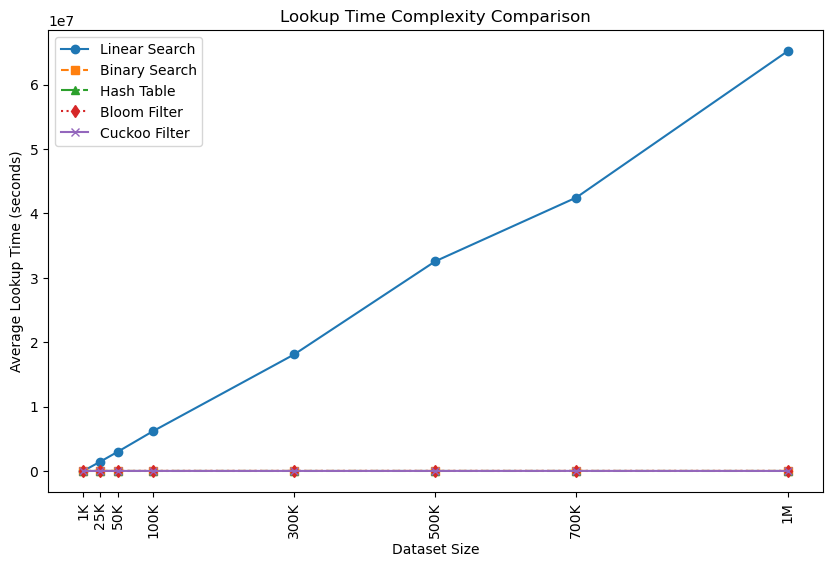

In [21]:
custom_labels = ["1K", "25K", "50K", "100K", "300K", "500K", "700K", "1M"]

plt.figure(figsize=(10, 6))

plt.plot(dataset_sizes, linear_search_times, marker='o', label="Linear Search", linestyle='-')
plt.plot(dataset_sizes, binary_search_times, marker='s', label="Binary Search", linestyle='--')
plt.plot(dataset_sizes, hash_table_times, marker='^', label="Hash Table", linestyle='-.')
plt.plot(dataset_sizes, bloom_filter_times, marker='d', label="Bloom Filter", linestyle=':')
plt.plot(dataset_sizes, cuckoo_filter_times, marker='x', label="Cuckoo Filter", linestyle='-')

plt.xlabel("Dataset Size")
plt.ylabel("Average Lookup Time (seconds)")
plt.xticks(dataset_sizes, custom_labels)
plt.xticks(rotation=90)
plt.title("Lookup Time Complexity Comparison")
plt.legend()
plt.show()

## Step 4: Unit test for hashing, bloom and cucko filter

In [22]:
# Unit Testing

class TestFilters(unittest.TestCase):
    def setUp(self):
        self.hash_table = HashTable()
        self.bloom_filter = BloomFilter(1000, 3)
        self.cuckoo_filter = CuckooFilter(capacity=100000, bucket_size=4, fingerprint_size=16)
        self.sample_key = "test_user"
    
    def test_insert_and_lookup(self):
        #hash table
        self.hash_table.insert(self.sample_key)
        self.assertTrue(self.hash_table.lookup(self.sample_key))
        # Bloom filter
        self.bloom_filter.insert(self.sample_key)
        self.assertTrue(self.bloom_filter.lookup(self.sample_key))
        #Cuckoo
        self.cuckoo_filter.insert(self.sample_key)
        self.assertTrue(self.cuckoo_filter.lookup(self.sample_key))
    
    def test_delete(self):
        self.hash_table.insert(self.sample_key)
        self.hash_table.delete(self.sample_key)
        self.assertFalse(self.hash_table.lookup(self.sample_key))
        
        self.cuckoo_filter.insert(self.sample_key)
        self.cuckoo_filter.delete(self.sample_key)
        self.assertFalse(self.cuckoo_filter.lookup(self.sample_key))

if __name__ == "__main__":
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


..
----------------------------------------------------------------------
Ran 2 tests in 0.335s

OK
